In [54]:
#standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time as time

from warnings import filterwarnings
filterwarnings('ignore')

In [55]:
#load dataset
df=pd.read_csv('train_edited1.csv') #training set with preprocessing already implemented
#labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('test_preds_added1.csv')# this is the testing data with one iteration of predictions
#fill NaNs - ffill bc it is a timeseries
df.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
#to datetime
df['week_start_date']=pd.to_datetime(df['week_start_date'])
test['week_start_date']=pd.to_datetime(test['week_start_date'])
#extract month to new column
df['month']=df.week_start_date.dt.month
test['month']=test.week_start_date.dt.month
#merge labels
#df=pd.merge(df, labels, on=['city', 'year', 'weekofyear'])

In [56]:
df.rename(columns={'total_cases_x': 'total_cases'}, inplace=True)

In [57]:

sj = df[df['city']=='sj']
iq = df[df['city']=='iq']

sj_test=test[test['city']=='sj']
iq_test=test[test['city']=='iq']

In [58]:
#value previous week
#train
sj['cases_prev_wk'] = sj['total_cases'].shift(1)
iq['cases_prev_wk'] = iq['total_cases'].shift(1)

#test
sj_test['cases_prev_wk'] = sj_test['total_cases'].shift(1)
iq_test['cases_prev_wk'] = iq_test['total_cases'].shift(1)

#need to make sure no NaNs added when creating moving avg or getting previous week values
sj.fillna(method='bfill', inplace=True)
iq.fillna(method='bfill', inplace=True)

sj_test.fillna(method='bfill', inplace=True)
sj_test.fillna(method='bfill', inplace=True)

In [59]:
#these features performed better
features2=[
'total_cases_avg',                                      
'rolling_avg_reanalysis_specific_humidity_g_per_kg',    
'rolling_avg_station_avg_temp_c',                       
'rolling_avg_reanalysis_dew_point_temp_k',              
'rolling_avg_station_min_temp_c',                       
'rolling_avg_station_max_temp_c',                       
'rolling_avg_reanalysis_min_air_temp_k',                
'rolling_avg_reanalysis_max_air_temp_k',                
'rolling_avg_reanalysis_air_temp_k',                    
'rolling_avg_reanalysis_avg_temp_k',            
'reanalysis_specific_humidity_g_per_kg',               
'reanalysis_dew_point_temp_k',                          
'reanalysis_min_air_temp_k',                           
'station_min_temp_c',
'cases_prev_wk',
'total_cases'
    ]      

#TRAIN
X_sj= sj[features2]
Y_sj = sj['total_cases']

X_iq= iq[features2]
Y_iq = iq['total_cases']

#TEST
X_sj_t= sj_test[features2]

X_iq_t= iq_test[features2]


#need to make sure no NaNs
X_sj.fillna(method='ffill', inplace=True)
X_iq.fillna(method='bfill', inplace=True)

X_sj_t.fillna(method='ffill', inplace=True)
X_iq_t.fillna(method='bfill', inplace=True)

In [60]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

def get_best_model(train, test):
    # Step 1: specify the form of the model
    
  

                    
    model_formula = "total_cases ~ 1 + " \
                    "rolling_avg_reanalysis_specific_humidity_g_per_kg + " \
                    "rolling_avg_reanalysis_dew_point_temp_k + " \
                    "rolling_avg_station_min_temp_c + " \
                    "rolling_avg_station_avg_temp_c + " \
                    "station_min_temp_c + "\
                    "reanalysis_dew_point_temp_k +" \
                    "cases_prev_wk"
                   
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [61]:
sj_best_model = get_best_model(X_sj,X_sj_t)
iq_best_model = get_best_model(X_iq,X_iq_t)

best alpha =  0.0001
best score =  13.066318004923756
best alpha =  1e-08
best score =  3.086527241302874


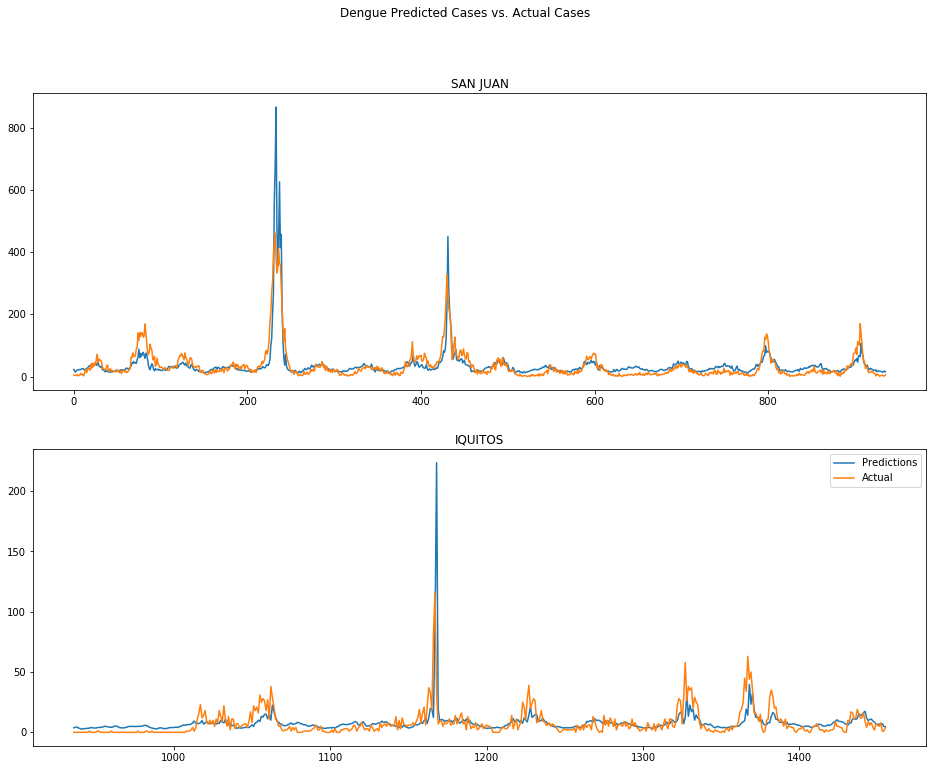

In [47]:
figs, axes = plt.subplots(nrows=2, ncols=1,figsize=(16, 12))

# plot sj
sj['fitted'] = sj_best_model.predict(X_sj)
sj.fitted.plot(ax=axes[0], label="Predictions")
sj.total_cases.plot(ax=axes[0], label="Actual", title="SAN JUAN")

# plot iq
iq['fitted'] = iq_best_model.predict(X_iq)
iq.fitted.plot(ax=axes[1], label="Predictions")
iq.total_cases.plot(ax=axes[1], label="Actual", title="IQUITOS")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()